In [1]:
import torch 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

from score_models import ScoreModel

import json

plt.style.use("dark_background")
sys.path.append("..\\scripts\\")
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_probes_g_64_230604024652/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_probes_g_64_230604024652")

def preprocess_probes_g_channel(img, inv_link = False):  # channel 0
    img = torch.clamp(img, 0, 1.48)
    
    if inv_link:
        img = 2 * img / 1.48 - 1.
    return img

def link_function(x):
    return (x + 1)/2

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")

def ftshift(x): 
    return torch.fft.fftshift(x)
    
from mpol import coordinates
from mpol.gridding import DirtyImager

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"


img_size = 64

In [2]:

sys.path.append("../../")
from uv_coverage import sim_uv_cov

# Simuating a uv coverage
h = 1e-2 # hours
grid, noise_rms, u, v, ants1, ants2 = sim_uv_cov(h) # u, v in meters
uv = torch.tensor(np.array([u, v]).transpose()).to(device)
# Gridding and calculating the counts in each cell of the grid
npix = 64
u_edges = np.linspace(u.min(), u.max(), npix + 1, endpoint = True)
v_edges = np.linspace(v.min(), v.max(), npix + 1, endpoint = True)

bin_x = u_edges
bin_y = v_edges
count, *_ = binned_statistic_2d(u, v, torch.ones(u.shape[0]), "count", (bin_x, bin_y))

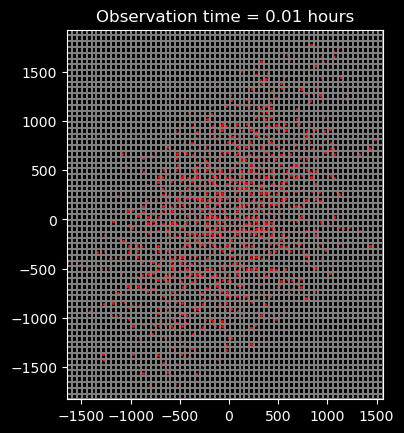

In [3]:
plt.plot(u, v, '.r', markersize=1)

for x_coord in u_edges: 
    plt.axvline(x = x_coord, color = "gray", linestyle = "-")

for y_coord in v_edges:
    plt.axhline(y =y_coord, color = "gray", linestyle = "-")
plt.title(f"Observation time = {h} hours")
plt.gca().set_aspect("equal")
plt.xlim([u.min(), u.max()])
plt.ylim([v.min(), v.max()])
plt.show()

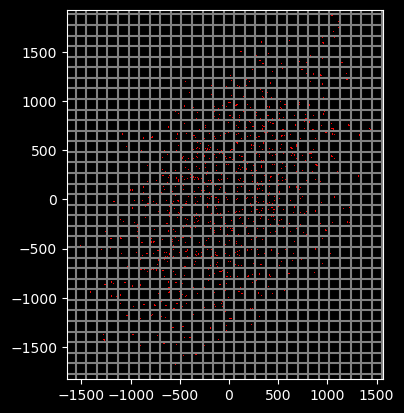

In [6]:
pixel_scale = 0.015 # arcsec
npix = 128 # Number of pixels in the grid
coords = coordinates.GridCoords(cell_size=pixel_scale, npix=npix)

plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")
for x_coord in coords.u_edges: 
    plt.axvline(x = x_coord, color = "gray", linestyle = "-")

for y_coord in coords.v_edges:
    plt.axhline(y =y_coord, color = "gray", linestyle = "-")

plt.xlim([u.min(), u.max()])
plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")

In [86]:
# Sampling function (=1 if count>0 and = 0 if count = 0)


c:\Users\noedi\Desktop\Ciela Research\ML code\interferometry\diffusion-radio-astronomy\notebooks\..\scripts\utils.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(dataset[idx, ..., 1])


RuntimeError: The size of tensor a (1784) must match the size of tensor b (0) at non-singleton dimension 0

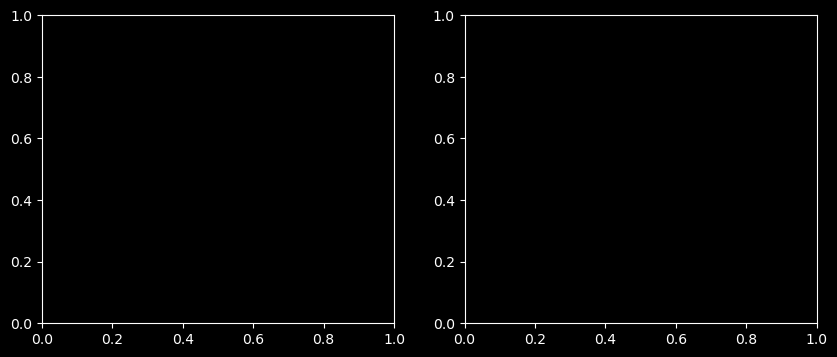

In [12]:
dataset = torch.load("../../true_prior.pt")
k = 74

img = probes_64(dataset, k).to(device)
img_size = img.shape[-1]
pad_size = int((npix - img_size)/2)
img = torch.nn.functional.pad(img, (pad_size, pad_size, pad_size, pad_size)) 


vis_full = ft(img)

sampling_function = torch.tensor(count>0).to(torch.bool)
S = ftshift(sampling_function).flatten().to(device)

vis_sampled = vis_full.flatten()[S]

vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
D = len(vis_sampled)

sigma_likelihood = 1e-4
sigma_y = sigma_likelihood * torch.ones(D).to(device)
eta = sigma_likelihood * torch.randn(D).to(device)

y = vis_sampled + eta 

# PLOTS #
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
dirty_image_noise = ift((y[:npix**2] + 1j * y[npix**2:]).reshape(npix, npix)).real

im = axs[0].imshow(img.reshape(npix, npix).cpu(), cmap = "hot")
axs[0].set_title("Ground-truth")
plt.colorbar(im)
im = axs[1].imshow(dirty_image_noise.cpu(), cmap = "hot")
axs[1].set_title("Dirty image with noise")
plt.colorbar(im)


In [14]:
y.shape

torch.Size([1784])

In [10]:
64 * 64 * 2

8192

The dirty image is defined as: 
$$
I_d = \mathcal{F}(SV)
$$

In [15]:
beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function(x) # map from model unit space to real unit space

    # Padding: 
    pad_size = int((npix - img_size)/2)
    x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size)) 
    vis_full = ft(x).flatten() 
    vis_sampled = vis_full[S]
    return torch.cat([vis_sampled.real, vis_sampled.imag])


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x)
    var = sigma(t) **2/2 + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(x, t): 
    x = x.flatten(start_dim = 1) # making sure the input is flattened
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 

tensor(0.0002, device='cuda:0')
tensor([[-0.0024, -0.0023,  0.0026,  ..., -0.0003,  0.0021, -0.0011]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [16]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean) 

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 4, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [00:22<00:00, 21.81it/s]


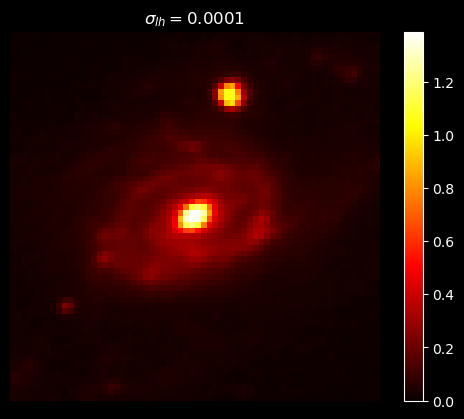

In [17]:
n_images = len(samples)

if n_images != 1:
    grid_size = int(n_images**0.5)
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (8, 8))

    a = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            axs[i, j].imshow(samples[a].cpu().reshape(img_size, img_size), cmap = "hot")
            axs[i, j].axis("off")
else: 
    plt.imshow(samples.cpu().reshape(img_size, img_size), cmap = "hot")
    plt.axis("off")
    plt.colorbar(fraction = 0.046)
    plt.title(r"$\sigma_{lh} = $" + f"{sigma_likelihood:1g}")